<a href="https://colab.research.google.com/github/Rajesh-Nimmalapudi/Pneumonia-Detection-Using-CNN/blob/main/pneumonia_final_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna mlflow pyngrok



In [ ]:
!mkdir -p /content/drive/MyDrive/pneumonia_safe


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
#importing tools and libraries to set up mlflow and optuna
!pip install optuna mlflow pyngrok -q
import optuna
import mlflow
from tensorflow.keras.layers import  BatchNormalization
from pyngrok import ngrok, conf
import time
from tensorflow.keras.layers import Input
import subprocess
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.4/741.4 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 17.3 MB/s eta 0:00:00


In [4]:
zip_path = '/content/drive/MyDrive/archive (6).zip'  # 👈 Update if yours has a different name
extract_path = '/content/dataset'  # You can rename this

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)

✅ Dataset extracted to: /content/dataset


In [5]:
#paths
train_path = "/content/dataset/chest_xray/chest_xray/train"
val_path   = "/content/dataset/chest_xray/chest_xray/val"
test_path  = "/content/dataset/chest_xray/chest_xray/test"


In [6]:
#folder to save mllogs
!mkdir -p /content/drive/MyDrive/pneumonia_safe/mlruns
# saving mlflow logs
import os
os.environ["MLFLOW_TRACKING_URI"] = "file:///content/drive/MyDrive/pneumonia_safe/mlruns"


In [ ]:



conf.get_default().auth_token = "2zwmiqOFaCXR54eLO603kpMUKFa_7tQpFzvtSD9virmUY996p"  # Replace with your actual token
ngrok.kill()




mlflow_port = 5000

# ✅ STEP 5: Start MLflow UI
mlflow_process = subprocess.Popen(["mlflow", "ui", "--port", str(mlflow_port)])
time.sleep(10)

# ✅ STEP 6: Expose MLflow UI with ngrok
mlflow_url = ngrok.connect(mlflow_port)
print(f"🔗 Open MLflow UI: {mlflow_url.public_url}")

# ✅ STEP 7: Set MLflow Tracking URI to the ngrok public URL
mlflow.set_tracking_uri(mlflow_url.public_url)
mlflow.set_experiment("cnn_pneumonia_tuning_v2")



🔗 Open MLflow UI: https://21a31ab4490a.ngrok-free.app


<Experiment: artifact_location='mlflow-artifacts:/405400058810872408', creation_time=1752663788065, experiment_id='405400058810872408', last_update_time=1752663788065, lifecycle_stage='active', name='cnn_pneumonia_tuning_v2', tags={}>

In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="cnn_pneumonia_tuning_v2",
    storage="sqlite:///drive/MyDrive/pneumonia_safe/cnn_tuning_v2.db",
    load_if_exists=True
)


[I 2025-07-16 11:16:08,183] Using an existing study with name 'cnn_pneumonia_tuning_v2' instead of creating a new one.


In [18]:


train_gen = ImageDataGenerator(
    rescale=1./255,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    brightness_range=[0.8, 1.2],     # Simulates different exposure levels
    horizontal_flip=True,            # Most X-rays are symmetric
    fill_mode='nearest'              # Fills empty pixels after shift/rotate
)

val_gen = ImageDataGenerator(
    rescale = 1./255
)

test_gen = ImageDataGenerator(
    rescale = 1./255
)


In [19]:
#data generation with augumentation
train_data = train_gen.flow_from_directory(
    train_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'

)
val_data = val_gen.flow_from_directory(
    val_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'

)
test_data = test_gen.flow_from_directory(
    test_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary',
    shuffle=False

)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Shape of images in a batch: (32, 150, 150, 3)


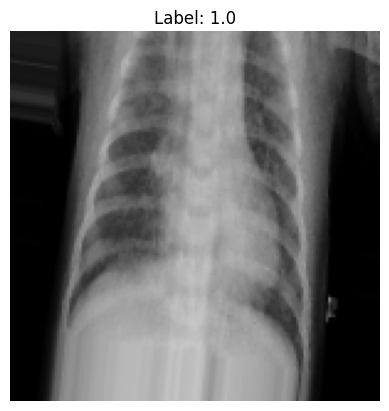

In [20]:
# Get a batch of images and labels from the training data generator
images, labels = next(train_data)

# Print the shape of the images in the batch
print("Shape of images in a batch:", images.shape)

# Display the first image in the batch
plt.imshow(images[3])
plt.title(f"Label: {labels[3]}")
plt.axis('off')
plt.show()

In [ ]:
# ✅ STEP 6: Model builder function (with hyperparameters to tune)
def create_model(trial):


    filters = trial.suggest_categorical("filters", [32, 64, 128])
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5])
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    dense_units = trial.suggest_categorical("dense_units", [64, 128, 256])
    init = trial.suggest_categorical("init", ["he_uniform", "glorot_uniform"])
    use_batch_norm = trial.suggest_categorical("batch_norm", [True, False])

    model = Sequential()
    model.add(Input(shape=(150, 150, 3)))
    model.add(Conv2D(filters, kernel_size, activation=activation, kernel_initializer=init))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ✅ STEP 7: Define Optuna objective function
def objective(trial):

    model = create_model(trial)

    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    with mlflow.start_run():
        history = model.fit(train_data,  # ← Set your training data
                            epochs=10,
                            validation_data=val_data,  # ← Set your validation data
                            callbacks=[early_stop],
                            verbose=0)

        val_acc = max(history.history['val_accuracy'])

        # Log all parameters and metrics
        for key, value in trial.params.items():
            mlflow.log_param(key, value)
        mlflow.log_metric("val_accuracy", val_acc)

        # Progress tracking
        print(f"Trial {trial.number} completed → Val Accuracy: {val_acc:.4f}")
        print(f"Params: {trial.params}\n")
        print(f"🔗 View run in MLflow: {mlflow.get_tracking_uri()}/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")

        return val_acc

# ✅ STEP 8: Start tuning
study.optimize(objective, n_trials=30)

# ✅ STEP 9: Show best result
print("✅ Best Accuracy:", study.best_value)
print("✅ Best Parameters:", study.best_params)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Trial 2 completed → Val Accuracy: 0.5000
Params: {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.4569608685869849, 'lr': 0.0028894384389506105, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'he_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/65f67068886641d68a8144b94ce5dabc
🏃 View run skittish-fawn-74 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/65f67068886641d68a8144b94ce5dabc
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 11:21:25,482] Trial 2 finished with value: 0.5 and parameters: {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.4569608685869849, 'lr': 0.0028894384389506105, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'he_uniform', 'batch_norm': True}. Best is trial 2 with value: 0.5.


Trial 3 completed → Val Accuracy: 0.6875
Params: {'filters': 32, 'kernel_size': 5, 'activation': 'tanh', 'dropout': 0.2797839072826259, 'lr': 5.803562905169732e-05, 'optimizer': 'adam', 'dense_units': 64, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/fa68bc5d3f7a459f9007f2cb0de870c1
🏃 View run receptive-lamb-146 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/fa68bc5d3f7a459f9007f2cb0de870c1
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 11:28:35,425] Trial 3 finished with value: 0.6875 and parameters: {'filters': 32, 'kernel_size': 5, 'activation': 'tanh', 'dropout': 0.2797839072826259, 'lr': 5.803562905169732e-05, 'optimizer': 'adam', 'dense_units': 64, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 3 with value: 0.6875.


Trial 4 completed → Val Accuracy: 0.5000
Params: {'filters': 64, 'kernel_size': 5, 'activation': 'tanh', 'dropout': 0.36510628915674526, 'lr': 3.488816104396271e-05, 'optimizer': 'adam', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': False}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/f04ac0e30583471dbe9c48adc1998b59
🏃 View run angry-deer-231 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/f04ac0e30583471dbe9c48adc1998b59
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 11:33:43,627] Trial 4 finished with value: 0.5 and parameters: {'filters': 64, 'kernel_size': 5, 'activation': 'tanh', 'dropout': 0.36510628915674526, 'lr': 3.488816104396271e-05, 'optimizer': 'adam', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': False}. Best is trial 3 with value: 0.6875.


Trial 5 completed → Val Accuracy: 0.6250
Params: {'filters': 128, 'kernel_size': 3, 'activation': 'tanh', 'dropout': 0.35800245448419066, 'lr': 0.00020792938051033587, 'optimizer': 'rmsprop', 'dense_units': 256, 'init': 'he_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/4572460837ff4c24b1d858034d398de4
🏃 View run adaptable-slug-616 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/4572460837ff4c24b1d858034d398de4
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 11:48:48,972] Trial 5 finished with value: 0.625 and parameters: {'filters': 128, 'kernel_size': 3, 'activation': 'tanh', 'dropout': 0.35800245448419066, 'lr': 0.00020792938051033587, 'optimizer': 'rmsprop', 'dense_units': 256, 'init': 'he_uniform', 'batch_norm': True}. Best is trial 3 with value: 0.6875.


Trial 6 completed → Val Accuracy: 0.5000
Params: {'filters': 128, 'kernel_size': 5, 'activation': 'tanh', 'dropout': 0.25020877532442864, 'lr': 0.00426592927513016, 'optimizer': 'rmsprop', 'dense_units': 64, 'init': 'he_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/73cdf650770d4867bf69f9defc90de2c
🏃 View run invincible-kit-982 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/73cdf650770d4867bf69f9defc90de2c
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 11:55:38,136] Trial 6 finished with value: 0.5 and parameters: {'filters': 128, 'kernel_size': 5, 'activation': 'tanh', 'dropout': 0.25020877532442864, 'lr': 0.00426592927513016, 'optimizer': 'rmsprop', 'dense_units': 64, 'init': 'he_uniform', 'batch_norm': True}. Best is trial 3 with value: 0.6875.


Trial 7 completed → Val Accuracy: 0.5000
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.4374377561908737, 'lr': 0.00014721945736422438, 'optimizer': 'rmsprop', 'dense_units': 256, 'init': 'he_uniform', 'batch_norm': False}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/3c576b40b73a4d91bf2d5ca32027f1c7
🏃 View run invincible-duck-373 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/3c576b40b73a4d91bf2d5ca32027f1c7
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 12:03:26,480] Trial 7 finished with value: 0.5 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.4374377561908737, 'lr': 0.00014721945736422438, 'optimizer': 'rmsprop', 'dense_units': 256, 'init': 'he_uniform', 'batch_norm': False}. Best is trial 3 with value: 0.6875.


Trial 8 completed → Val Accuracy: 0.6875
Params: {'filters': 128, 'kernel_size': 5, 'activation': 'relu', 'dropout': 0.44284434678520374, 'lr': 2.8888372072589297e-05, 'optimizer': 'adam', 'dense_units': 256, 'init': 'glorot_uniform', 'batch_norm': False}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/d8f148cd260f4a7786c14f887f050436
🏃 View run luxuriant-auk-119 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/d8f148cd260f4a7786c14f887f050436
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 12:17:49,037] Trial 8 finished with value: 0.6875 and parameters: {'filters': 128, 'kernel_size': 5, 'activation': 'relu', 'dropout': 0.44284434678520374, 'lr': 2.8888372072589297e-05, 'optimizer': 'adam', 'dense_units': 256, 'init': 'glorot_uniform', 'batch_norm': False}. Best is trial 3 with value: 0.6875.


Trial 9 completed → Val Accuracy: 0.5000
Params: {'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout': 0.493319812741713, 'lr': 0.004570850529632961, 'optimizer': 'adam', 'dense_units': 128, 'init': 'he_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/07344f6acdb14b25824ccf04a145f739
🏃 View run mysterious-midge-626 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/07344f6acdb14b25824ccf04a145f739
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 12:24:47,366] Trial 9 finished with value: 0.5 and parameters: {'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout': 0.493319812741713, 'lr': 0.004570850529632961, 'optimizer': 'adam', 'dense_units': 128, 'init': 'he_uniform', 'batch_norm': True}. Best is trial 3 with value: 0.6875.


Trial 10 completed → Val Accuracy: 0.9375
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.43658815854434946, 'lr': 0.0004455910135661276, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/8d6d8e44536c4d179bbccd57f03359be
🏃 View run smiling-tern-215 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/8d6d8e44536c4d179bbccd57f03359be
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 12:43:21,742] Trial 10 finished with value: 0.9375 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.43658815854434946, 'lr': 0.0004455910135661276, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 11 completed → Val Accuracy: 0.5000
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.49782247686267966, 'lr': 0.00023392421108589165, 'optimizer': 'sgd', 'dense_units': 256, 'init': 'glorot_uniform', 'batch_norm': False}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/889b64ca37374100be912465223484f6
🏃 View run powerful-ant-595 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/889b64ca37374100be912465223484f6
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 12:51:07,114] Trial 11 finished with value: 0.5 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.49782247686267966, 'lr': 0.00023392421108589165, 'optimizer': 'sgd', 'dense_units': 256, 'init': 'glorot_uniform', 'batch_norm': False}. Best is trial 10 with value: 0.9375.


Trial 12 completed → Val Accuracy: 0.7500
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.31044372324111214, 'lr': 0.0010195264379172261, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/302c659794b8496dbe3ac3cdc284e0a9
🏃 View run popular-wolf-49 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/302c659794b8496dbe3ac3cdc284e0a9
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 13:01:51,238] Trial 12 finished with value: 0.75 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.31044372324111214, 'lr': 0.0010195264379172261, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 13 completed → Val Accuracy: 0.8125
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3103149249732144, 'lr': 0.00116805419859398, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/ea653988d162492db0b483d181960e77
🏃 View run bustling-stork-657 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/ea653988d162492db0b483d181960e77
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 13:20:00,203] Trial 13 finished with value: 0.8125 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3103149249732144, 'lr': 0.00116805419859398, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 14 completed → Val Accuracy: 0.8750
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3870266605073258, 'lr': 0.0007672490619360577, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/4a5c66713640441b8e18fdda898f22f2
🏃 View run wistful-ape-437 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/4a5c66713640441b8e18fdda898f22f2
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 13:34:36,703] Trial 14 finished with value: 0.875 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3870266605073258, 'lr': 0.0007672490619360577, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 15 completed → Val Accuracy: 0.8750
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.39944664396168517, 'lr': 0.00071119652653388, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/548101ac2ed341029a17b6438e2772a3
🏃 View run debonair-bass-106 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/548101ac2ed341029a17b6438e2772a3
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 13:47:47,028] Trial 15 finished with value: 0.875 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.39944664396168517, 'lr': 0.00071119652653388, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 16 completed → Val Accuracy: 0.6250
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.39314998989777206, 'lr': 0.0005271144413774827, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/8ff7dfd49d77447690fb2003decf9c6a
🏃 View run grandiose-foal-578 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/8ff7dfd49d77447690fb2003decf9c6a
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 13:58:32,128] Trial 16 finished with value: 0.625 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.39314998989777206, 'lr': 0.0005271144413774827, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 17 completed → Val Accuracy: 0.8750
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.40336601364102254, 'lr': 0.0015477665615626635, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/1dca7567fd284aa4823d96760b1db9b5
🏃 View run sassy-lynx-1000 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/1dca7567fd284aa4823d96760b1db9b5
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 14:13:40,497] Trial 17 finished with value: 0.875 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.40336601364102254, 'lr': 0.0015477665615626635, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 18 completed → Val Accuracy: 0.6875
Params: {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.31942501671812595, 'lr': 0.009568498164849214, 'optimizer': 'sgd', 'dense_units': 64, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/57021ea2a5e34ccda9a404ca4dc7c5bb
🏃 View run bright-worm-441 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/57021ea2a5e34ccda9a404ca4dc7c5bb
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 14:19:21,226] Trial 18 finished with value: 0.6875 and parameters: {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.31942501671812595, 'lr': 0.009568498164849214, 'optimizer': 'sgd', 'dense_units': 64, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 19 completed → Val Accuracy: 0.8125
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.21309416422024027, 'lr': 9.365789691361113e-05, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/232043653fe34913b1c4d36f305291aa
🏃 View run debonair-conch-33 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/232043653fe34913b1c4d36f305291aa
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 14:32:32,442] Trial 19 finished with value: 0.8125 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.21309416422024027, 'lr': 9.365789691361113e-05, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 20 completed → Val Accuracy: 0.5000
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'tanh', 'dropout': 0.4232362449153307, 'lr': 1.404068025811426e-05, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': False}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/8e80525885174f52bdbc074e44b6bb14
🏃 View run zealous-shoat-6 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/8e80525885174f52bdbc074e44b6bb14
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 14:39:17,588] Trial 20 finished with value: 0.5 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'tanh', 'dropout': 0.4232362449153307, 'lr': 1.404068025811426e-05, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': False}. Best is trial 10 with value: 0.9375.


Trial 21 completed → Val Accuracy: 0.6875
Params: {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.46796976705528737, 'lr': 0.0003736359364250642, 'optimizer': 'rmsprop', 'dense_units': 64, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/5964511defc14b5791aeb0c482aa1252
🏃 View run capable-grouse-231 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/5964511defc14b5791aeb0c482aa1252
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 14:50:03,567] Trial 21 finished with value: 0.6875 and parameters: {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.46796976705528737, 'lr': 0.0003736359364250642, 'optimizer': 'rmsprop', 'dense_units': 64, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 22 completed → Val Accuracy: 0.5000
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.36400173123516444, 'lr': 0.0025897769204187146, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/33921192933b4e2986118fb260bd403b
🏃 View run calm-goat-452 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/33921192933b4e2986118fb260bd403b
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 14:56:24,321] Trial 22 finished with value: 0.5 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.36400173123516444, 'lr': 0.0025897769204187146, 'optimizer': 'rmsprop', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 23 completed → Val Accuracy: 0.5625
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3995146068372775, 'lr': 0.0006215224022779755, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/642d4a85b95947d3b955561d496c5dc3
🏃 View run skittish-hog-345 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/642d4a85b95947d3b955561d496c5dc3
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 15:03:42,649] Trial 23 finished with value: 0.5625 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3995146068372775, 'lr': 0.0006215224022779755, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 24 completed → Val Accuracy: 0.8125
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3896998040908869, 'lr': 0.0006399713737134153, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/75086b3a2bf247979206dda2729e0753
🏃 View run shivering-shad-344 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/75086b3a2bf247979206dda2729e0753
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 15:15:54,556] Trial 24 finished with value: 0.8125 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3896998040908869, 'lr': 0.0006399713737134153, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 25 completed → Val Accuracy: 0.6250
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3323617831174143, 'lr': 0.00036822653484459513, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/841a1e041f494038b999e2954ffc48c6
🏃 View run stylish-eel-325 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/841a1e041f494038b999e2954ffc48c6
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 15:28:29,423] Trial 25 finished with value: 0.625 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.3323617831174143, 'lr': 0.00036822653484459513, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 26 completed → Val Accuracy: 0.6875
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.4176645461944641, 'lr': 0.0017067756146278807, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/f9f95773c7af4620bc18e2fca016e418
🏃 View run adorable-dove-368 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/f9f95773c7af4620bc18e2fca016e418
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 15:39:28,734] Trial 26 finished with value: 0.6875 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.4176645461944641, 'lr': 0.0017067756146278807, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 27 completed → Val Accuracy: 0.7500
Params: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.38076527208073774, 'lr': 0.0008385924123418563, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/7e01f4fc46f64e6ba794ca8dc56316be
🏃 View run caring-perch-9 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/7e01f4fc46f64e6ba794ca8dc56316be
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 15:52:33,873] Trial 27 finished with value: 0.75 and parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout': 0.38076527208073774, 'lr': 0.0008385924123418563, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'glorot_uniform', 'batch_norm': True}. Best is trial 10 with value: 0.9375.


Trial 28 completed → Val Accuracy: 0.6250
Params: {'filters': 64, 'kernel_size': 5, 'activation': 'tanh', 'dropout': 0.4755599943105645, 'lr': 0.000129808530186191, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'he_uniform', 'batch_norm': False}

🔗 View run in MLflow: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/78f41f241ce648d58f32d46a55ce0d9c
🏃 View run illustrious-lamb-462 at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408/runs/78f41f241ce648d58f32d46a55ce0d9c
🧪 View experiment at: https://21a31ab4490a.ngrok-free.app/#/experiments/405400058810872408


[I 2025-07-16 16:00:40,292] Trial 28 finished with value: 0.625 and parameters: {'filters': 64, 'kernel_size': 5, 'activation': 'tanh', 'dropout': 0.4755599943105645, 'lr': 0.000129808530186191, 'optimizer': 'sgd', 'dense_units': 128, 'init': 'he_uniform', 'batch_norm': False}. Best is trial 10 with value: 0.9375.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /content/drive/MyDrive/pneumonia_safe
!cp -r mlruns /content/drive/MyDrive/pneumonia_safe/
!cp cnn_tuning_v2.db /content/drive/MyDrive/pneumonia_safe/


cp: cannot stat 'mlruns': No such file or directory
cp: cannot stat 'cnn_tuning_v2.db': No such file or directory


In [23]:

# ✅ Final model with best parameters from Optuna
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, initializers
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Best parameters
best_params = {
    'filters': 64,
    'kernel_size': 3,
    'activation': 'relu',
    'dropout': 0.4,
    'lr': 0.001,
    'optimizer': 'adam',
    'dense_units': 128,
    'init': 'glorot_uniform',
    'batch_norm': True
}

# Build model
def build_final_model(params):
    model = models.Sequential()
    model.add(layers.Input(shape=(150, 150, 3)))

    model.add(layers.Conv2D(params['filters'], ((3,3)), activation=params['activation'],
                            kernel_initializer=params['init'], padding='same'))
    if params['batch_norm']:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(params['dropout']))

    model.add(layers.Conv2D(params['filters']*2,((3,3)), activation=params['activation'],
                            kernel_initializer=params['init'], padding='same'))
    if params['batch_norm']:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(params['dropout']))

    model.add(layers.Flatten())
    model.add(layers.Dense(params['dense_units'], activation=params['activation'], kernel_initializer=params['init']))
    model.add(layers.Dropout(params['dropout']))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

model = build_final_model(best_params)

# Compile
optimizer_dict = {
    'adam': optimizers.Adam(learning_rate=best_params['lr']),
    'sgd': optimizers.SGD(learning_rate=best_params['lr']),
    'rmsprop': optimizers.RMSprop(learning_rate=best_params['lr'])
}
model.compile(optimizer=optimizer_dict[best_params['optimizer']],
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',     # You can also use 'val_accuracy'
    patience=3,             # Number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)
# Train the final model
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping])

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

# Save model
model.save("pneumonia_best_model.h5")




Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 506ms/step - accuracy: 0.6921 - loss: 7.8968 - val_accuracy: 0.5000 - val_loss: 38.8157
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.7515 - loss: 0.4820 - val_accuracy: 0.5000 - val_loss: 43.3658
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 484ms/step - accuracy: 0.7474 - loss: 0.3945 - val_accuracy: 0.5000 - val_loss: 36.5200
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.7615 - loss: 0.4245 - val_accuracy: 0.5000 - val_loss: 5.8358
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 473ms/step - accuracy: 0.8533 - loss: 0.3447 - val_accuracy: 0.5625 - val_loss: 0.6802
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 474ms/step - accuracy: 0.8514 - loss: 0.3576 - val_accuracy: 0.6250 - val_loss: 3.5161
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 485ms/step - accuracy: 0.8665 - loss: 0.3278 - val_accuracy: 0.5000 - val_loss: 0.6071
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 466ms/step - accuracy: 0.8694 - loss

Test Accuracy: 0.7628


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step


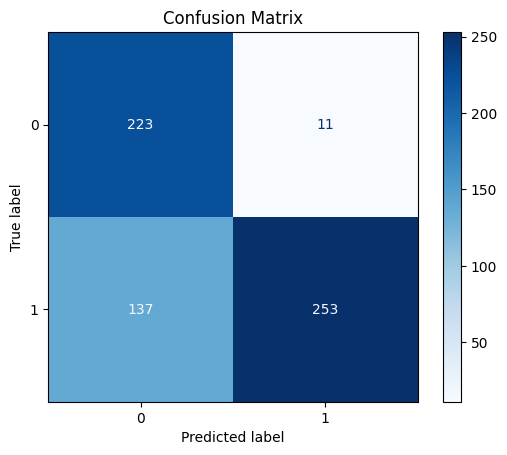

In [28]:
# Predict and plot confusion matrix
# Compute steps
steps = int(np.ceil(test_data.samples / test_data.batch_size))
y_true = test_data.classes
# Predict with known steps
y_pred_prob = model.predict(
    test_data,
    steps=steps,
    verbose=1,

)



y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [30]:
!cp pneumonia_best_model.h5 /content/drive/MyDrive/
